In [1]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, BertConfig
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
model_raw_path = "/home/newdisk/wkh/GAN/transformers-master/examples/pytorch/text-classification/PLM/bert_base/"
model_base_path = "/home/newdisk/wkh/GAN/transformers-master/examples/pytorch/text-classification/checkpoint/rte_dev_best/lr_5/checkpoint-250/"
model_cl_path = "/home/newdisk/wkh/GAN/transformers-master/examples/pytorch/text-classification/CL/random/rte/all-layer-32-5/1-dev-0.7-0.001-lr_5-seed42/"
model_raw = BertModel.from_pretrained(model_raw_path, output_hidden_states=True).cuda()
model_base = BertModel.from_pretrained(model_base_path, output_hidden_states=True).cuda()
model_cl = BertModel.from_pretrained(model_cl_path,output_hidden_states=True).cuda()
tokenizer = BertTokenizer.from_pretrained(model_cl_path)

Some weights of the model checkpoint at /home/newdisk/wkh/GAN/transformers-master/examples/pytorch/text-classification/PLM/bert_base/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/newdisk/wkh/GAN/transformers-mast

In [3]:
def l2_normal(embedding):
    a = torch.matmul(embedding,embedding.T)
    return torch.sqrt(a)
def token_sim(outputs):
    sim = torch.zeros(13)
    for layer in range(len(outputs)):
        sim_layer = 0
        this_layer = outputs[layer]
        num_total = 0
        for token in range(outputs[0].size(1)-1):
            for token_next in range(token+1,outputs[0].size(1)):
                num_total += 1
                l2_token = l2_normal(this_layer[:,token])
                l2_token_next = l2_normal(this_layer[:,token_next])
                value = torch.matmul(this_layer[:,token],this_layer[:,token_next].T)
                sim_layer += value / (l2_token * l2_token_next)
        sim[layer] = sim_layer/num_total
    return sim
def ave_sim(path,models):
    f = open(path,'r',encoding='utf-8')
    sim_raw_total = 0.
    sim_base_total = 0.
    sim_cl_total = 0.
    model_raw, model_base, model_cl = models
    model_raw.eval()
    model_base.eval()
    model_cl.eval()
    for index, line in enumerate(f):
        print("process: ",index)
        num = index + 1
        data = line.rstrip().split('\t')
        sen1 = data[0]
        sen2 = data[1]
        inputs = tokenizer(sen1,sen2,return_tensors='pt').to(model_raw.device)
        with torch.no_grad():
            outputs_raw = model_raw(**inputs)
            outputs_base = model_base(**inputs)
            outputs_cl = model_cl(**inputs)
        sim_raw = token_sim(outputs_raw.hidden_states)
        sim_base = token_sim(outputs_base.hidden_states)
        sim_cl = token_sim(outputs_cl.hidden_states)
        sim_raw_total += sim_raw
        sim_base_total += sim_base
        sim_cl_total += sim_cl
    f.close()
    return sim_raw_total / num, sim_base_total / num, sim_cl_total / num

In [4]:
'''
path_mrpc = "/home/newdisk/wkh/GAN/transformers-master/examples/pytorch/text-classification/data/rte/dev_sub.txt"
models = [model_raw,model_base,model_cl]
sim_raw, sim_base, sim_cl = ave_sim(path_mrpc, models)
layer = torch.arange(13).numpy()
sim_raw = sim_raw.cpu().numpy()
sim_base = sim_base.cpu().numpy()
sim_cl = sim_cl.cpu().numpy()
plt.plot(layer,sim_raw,'b',layer,sim_base,'g',layer,sim_cl,'red')
plt.legend(["pretrained_model","finetune_model","cl_model"])
plt.show()
'''

'\npath_mrpc = "/home/newdisk/wkh/GAN/transformers-master/examples/pytorch/text-classification/data/rte/dev_sub.txt"\nmodels = [model_raw,model_base,model_cl]\nsim_raw, sim_base, sim_cl = ave_sim(path_mrpc, models)\nlayer = torch.arange(13).numpy()\nsim_raw = sim_raw.cpu().numpy()\nsim_base = sim_base.cpu().numpy()\nsim_cl = sim_cl.cpu().numpy()\nplt.plot(layer,sim_raw,\'b\',layer,sim_base,\'g\',layer,sim_cl,\'red\')\nplt.legend(["pretrained_model","finetune_model","cl_model"])\nplt.show()\n'

In [5]:
sen1 = 'The San Diego Padres ace, Jake Peavy, was hurt in an 8-5 loss to the St. Louis Cardinals.'
sen2 = 'The San Diego Padres won the game against the St. Louis Cardinals.'
inputs = tokenizer(sen1,sen2,return_tensors='pt').to(model_raw.device)
with torch.no_grad():
    outputs_raw = model_raw(**inputs)
    outputs_base = model_base(**inputs)
    outputs_cl = model_cl(**inputs)

In [6]:
print(inputs)

{'input_ids': tensor([[  101,  1996,  2624,  5277, 21577,  9078,  1010,  5180, 26034, 10736,
          1010,  2001,  3480,  1999,  2019,  1022,  1011,  1019,  3279,  2000,
          1996,  2358,  1012,  3434,  9310,  1012,   102,  1996,  2624,  5277,
         21577,  2180,  1996,  2208,  2114,  1996,  2358,  1012,  3434,  9310,
          1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


In [44]:
def cos_sim(embedding1,embedding2):
    l2_1 = l2_normal(embedding1)
    l2_2 = l2_normal(embedding2)
    value = torch.matmul(embedding1,embedding2.T)
    return value / (l2_1 * l2_2)
def sim_check(outputs,sep_index):
    sim_sep = torch.zeros(13)
    for layer in range(len(outputs)):
        this_layer = outputs[layer]
        token_sep = this_layer[:,sep_index[0]]
        sub_sim = 0.
        num_token = 0
        for token in range(1, this_layer.size(1)):
            if token in sep_index:
                pass
            num_token += 1
            token_1 = this_layer[:,token]
            sub_sim += cos_sim(token_1,token_sep)
        sim_sep[layer] = sub_sim/num_token
    return sim_sep
def sep_sim_check(path, models):
    f = open(path,'r',encoding='utf-8')
    sim_raw_total = 0.
    sim_base_total = 0.
    sim_cl_total = 0.
    model_raw, model_base, model_cl = models
    model_raw.eval()
    model_base.eval()
    model_cl.eval()
    for index, line in enumerate(f):
        print("process: ",index)
        num = index + 1
        data = line.rstrip().split('\t')
        sen1 = data[0]
        sen2 = data[1]
        sep_index = []
        inputs = tokenizer(sen1,sen2,return_tensors='pt',max_length=128,truncation=True,padding=True).to(model_raw.device)
        for index in range(inputs["input_ids"].size(-1)):
            if inputs["input_ids"][0,index] == 102:
                sep_index.append(index)
        with torch.no_grad():
            outputs_raw = model_raw(**inputs)
            outputs_base = model_base(**inputs)
            outputs_cl = model_cl(**inputs)
        sim_sep_raw = sim_check(outputs_raw.hidden_states,sep_index=sep_index)
        sim_sep_base = sim_check(outputs_base.hidden_states,sep_index=sep_index)
        sim_sep_cl = sim_check(outputs_cl.hidden_states,sep_index=sep_index)
        sim_raw_total += sim_sep_raw
        sim_base_total += sim_sep_base
        sim_cl_total += sim_sep_cl
    f.close()
    return sim_raw_total / num, sim_base_total / num, sim_cl_total / num

In [45]:
path_mrpc = "/home/newdisk/wkh/GAN/transformers-master/examples/pytorch/text-classification/data/rte/dev_sub.txt"
models = [model_raw,model_base,model_cl]
sim_sep_raw, sim_sep_base, sim_sep_cl = sep_sim_check(path_mrpc, models)

process:  0
process:  1


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


process:  2


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


process:  3
process:  4
process:  5
process:  6
process:  7
process:  8
process:  9
process:  10
process:  11
process:  12
process:  13
process:  14
process:  15
process:  16
process:  17
process:  18
process:  19
process:  20


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


process:  21


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


process:  22


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


process:  23


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


process:  24
process:  25
process:  26
process:  27
process:  28
process:  29


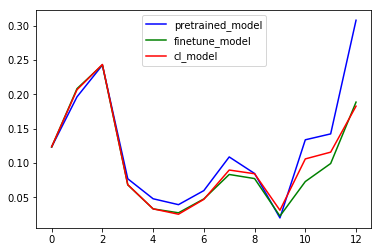

In [46]:
layer = torch.arange(13).numpy()

plt.plot(layer,sim_sep_raw,'b',layer,sim_sep_base,'g',layer,sim_sep_cl,'red')
plt.legend(["pretrained_model","finetune_model","cl_model"])
plt.show()

In [ ]:
plt.plot(layer,sim_same_raw,'b',layer,sim_same_base,'g',layer,sim_same_cl,'red')
plt.legend(["pretrained_model","finetune_model","cl_model"])
plt.show()

In [19]:
print(inputs)

{'input_ids': tensor([[  101,  1996,  2624,  5277, 21577,  9078,  1010,  5180, 26034, 10736,
          1010,  2001,  3480,  1999,  2019,  1022,  1011,  1019,  3279,  2000,
          1996,  2358,  1012,  3434,  9310,  1012,   102,  1996,  2624,  5277,
         21577,  2180,  1996,  2208,  2114,  1996,  2358,  1012,  3434,  9310,
          1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


In [34]:
print(inputs["input_ids"][0,1])

tensor(1996, device='cuda:0')


In [36]:
for index in range(inputs["input_ids"].size(-1)):
    if inputs["input_ids"][0,index] == 102:
        print(index)

26
41
